In [14]:
# Imports:
%reload_ext autoreload
%autoreload 2

# Data manipulation:
import numpy as np
import pandas as pd
import re
import string
import time
from typing import Tuple
# Data visualization:
import matplotlib.pyplot as plt
%matplotlib inline

# Data splitting:
from sklearn.model_selection import train_test_split

# Deep learning Modelling
import torch
import torch.nn as nn

# Text preprocessing
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.vocab import Vocab

# Evaluation metrics:
from torchmetrics import Accuracy
from torchmetrics import Recall
from torchmetrics import Precision
from torchmetrics import F1Score

In [2]:
# Load data:
df = pd.read_csv("../data/processed/labelled_texts.csv")
df = df[['complaint_what_happened', 'topic']]

# Set label to index mapping and vice versa:
label_to_ix = {
    'Bank Account services': 0, 
    'Credit card or prepaid card': 1,
    'Mortgage/Loan': 2, 
    'Theft/Dispute Reporting': 3, 
    'Others': 4
}

ix_to_label = {
    0: 'Bank Account services', 
    1: 'Credit card or prepaid card',
    2: 'Mortgage/Loan', 
    3: 'Theft/Dispute Reporting', 
    4: 'Others'
}

In [3]:
# Split data:
X = df['complaint_what_happened'].tolist()
y = df['topic'].tolist()

# Split data into training, validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=42)

print(f"Train ratio split: {len(X_train)/ len(df):.1%}")
print(f"Validation ratio split: {len(X_val)/ len(df):.1%}")
print(f"Test ratio split: {len(X_test)/ len(df):.1%}")

Train ratio split: 80.0%
Validation ratio split: 10.0%
Test ratio split: 10.0%


# Util Functions for Text Preprocessing

In [4]:
tokenizer = get_tokenizer('basic_english')
stop_words = stopwords.words('english')

# Functions
def remove_punctuations(text: str) -> str:
    """Remove punctuations from a text.
    
    Args:
        text (str): Text.
    Returns:
        str: Text with removed punctuations.
    """
    pattern = f'[{re.escape(string.punctuation)}]'
    return re.sub(pattern, ' ', text)

def remove_numbers(text: str) -> str:
    """Remove numbers from a text.
    
    Args:
        text (str): Text.
    Returns:
        str: Text with numbers punctuations.
    """
    pattern = r'[0-9]'
    return re.sub(pattern, ' ', text)

def remove_confidential_information(text: str) -> str:
    """Remove confidential information from a text.
    
    Args:
        text (str): Text.
    Returns:
        str: Text with removed confidential information.
    """
    pattern = r'\b[Xx]{1,}\b'
    return re.sub(pattern, ' ', text)

def remove_extra_spaces(text: str) -> str:
    """Remove extra spaces or new lines from a text.
    
    Args:
        text (str): Text.
    Returns:
        str: Text with removed extra spaces or new lines.
    """
    pattern = r'\s+'
    return re.sub(pattern, ' ', text)

def remove_stopwords(text: str) -> str:
    """Remove stop words from text

    Args:
        text (str): Text.
    Returns:
        str: Text with stop words removed.
    """
    tokens = tokenizer(text)
    return ' '.join([token for token in tokens if token not in stop_words])

# source: https://www.ibm.com/topics/stemming-lemmatization#:~:text=The%20practical%20distinction%20between%20stemming,be%20found%20in%20the%20dictionary.
def get_wordnet_pos(tag: str) -> str:
    """Return wordnet constant value to do lemmatization based on their input word tag

    Args:
        tag (str): Tag name.
    Returns:
        str: Constant value for wordnet lemmatization.
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:         
        return wordnet.NOUN
    
def lemmatize(text: str) -> str:
    """Perform lemmatization using WordNetLemmatizer

    Args:
        tokens (str): Text.
    Returns:
        str: Lemmatized text.
    """
    tokens = tokenizer(text)
    pos_tags = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()  
    return ' '.join([lemmatizer.lemmatize(token, get_wordnet_pos(tag)) for token, tag in pos_tags])


def pad_sequence(tokens: list, max_length: int, post: bool=True) -> np.array:
    """Perform zero padding before or after the sequence.

    Args:
        tokens (str): Text.
    Returns:
        str: Padded sequences.
    """
    padded_tokens = None
    if len(tokens) < max_length:
        zeros = list(np.zeros(max_length - len(tokens)))
        if post:
            padded_tokens = tokens + zeros  # Add zeros after the seqeuence
        else:
            padded_tokens = zeros + tokens  # Add zeros before the seqeuence
    else:
        padded_tokens = tokens[:max_length]
    return padded_tokens

def generate_vocabulary(texts: list) -> Vocab:
    """Generates a vocabulary from a list of texts.

    Args:
        texts (list): A list of text strings to build the vocabulary from.
    Returns:
        Vocab: A vocabulary object containing the tokens and their corresponding indices.
    """
    def yield_tokens(texts: list):
        for text in texts:
            yield tokenizer(text.strip())
    # Generate vocabulary
    vocab = build_vocab_from_iterator(yield_tokens(texts), min_freq=2, specials=["<unk>"])
    vocab.set_default_index(vocab["<unk>"])
    return vocab

def calculate_max_length_sequence(texts: list) -> int:
    """Calculates the maximum length of token sequences from a list of texts.

    Args:
        texts (list): Texts.
    Returns:
        int: The maximum length of the tokenized sequences.
    """
    max_length = 0  
    for text in texts:
        max_length = max(max_length, len(tokenizer(text)))
    return max_length

# Dataset Class

In [5]:
from torch.utils.data import Dataset

class CustomerComplaintsDataset(Dataset):
    """
    A custom dataset for handling encoded customer complaints and their labels.

    Args:
        encoded_texts (list): List of encoded text sequences.
        encoded_labels (list): List of encoded labels corresponding to the text sequences.
        max_length (int): Maximum length of the text sequences.

    Attributes:
        encoded_texts (list): Stored list of encoded text sequences.
        encoded_labels (list): Stored list of encoded labels.
        max_length (int): Stored maximum length of the text sequences.
    """
    
    def __init__(self, encoded_texts: list, encoded_labels: list, max_length: int) -> None:
        super().__init__()
        self.encoded_texts = encoded_texts
        self.encoded_labels = encoded_labels
        self.max_length = max_length
    
    def __len__(self) -> int:
        """Total number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.encoded_labels)

    def __getitem__(self, idx) -> Tuple[list, int]:
        """sample from the dataset at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            Tuple[list, int]: (encoded_text, label) where encoded_text is the encoded text sequence and label is the corresponding label.
        """
        encoded_text = self.encoded_texts[idx]
        label = self.encoded_labels[idx]
        return encoded_text, label

# Text Preprocessing

In [6]:
def collate_fn(batch):
    texts, labels = [], []
    for text, label in batch:
        texts.append(text)
        labels.append(label)
    texts, labels = np.array(texts), np.array(labels)
    return torch.LongTensor(texts), torch.LongTensor(labels)

# Create text preprocessing pipeline
def preprocess_text(text: str) -> str:
    text = text.lower()
    text = remove_stopwords(text)
    text = remove_numbers(text)
    text = remove_punctuations(text)
    text = remove_confidential_information(text)
    text = remove_extra_spaces(text)
    text = lemmatize(text)
    return text

In [36]:
preprocessed_train_texts = [preprocess_text(text) for text in X_train]
preprocessed_val_texts = [preprocess_text(text) for text in X_val]
preprocessed_test_texts = [preprocess_text(text) for text in X_test]

vocab = generate_vocabulary(preprocessed_train_texts)
max_length = calculate_max_length_sequence(preprocessed_train_texts)
 
train_encoded_texts = [vocab(tokenizer(text)) for text in preprocessed_train_texts]
val_encoded_texts = [vocab(tokenizer(text)) for text in preprocessed_val_texts]
test_encoded_texts = [vocab(tokenizer(text)) for text in preprocessed_test_texts]

train_encoded_texts = [pad_sequence(tokens, max_length) for tokens in train_encoded_texts]
val_encoded_texts = [pad_sequence(tokens, max_length) for tokens in val_encoded_texts]
test_encoded_texts = [pad_sequence(tokens, max_length) for tokens in test_encoded_texts]

train_encoded_labels = [label_to_ix[label] for label in y_train]
val_encoded_labels = [label_to_ix[label] for label in y_val]
test_encoded_labels = [label_to_ix[label] for label in y_test]

In [37]:
train_dataset = CustomerComplaintsDataset(train_encoded_texts, train_encoded_labels, max_length)
val_dataset = CustomerComplaintsDataset(val_encoded_texts, val_encoded_labels, max_length)
test_dataset = CustomerComplaintsDataset(test_encoded_texts, test_encoded_labels, max_length)


train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

# Neural Network Class

In [38]:
class Net(nn.Module):
    """
    A neural network model for text classification.

    Args:
        vocab_size (int): Size of the vocabulary.
        embedding_size (int): Dimension of the embedding vectors.
        num_classes (int): Number of output classes.
        max_length (int): Maximum length of the input text sequences.

    Attributes:
        embedding (nn.Embedding): Embedding layer to convert input tokens to embeddings.
        flatten (nn.Flatten): Layer to flatten the embeddings.
        linear (nn.Linear): Linear layer for classification.
        log_softmax (nn.LogSoftmax): Log softmax layer for output normalization.
    """
    
    def __init__(self, vocab_size: int, embedding_size: int, num_classes: int, max_length: int):
        super(Net, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(embedding_size * max_length, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, text):
        """
        Defines the forward pass of the model.

        Args:
            text (torch.Tensor): Input tensor containing tokenized text sequences.
        Returns:
            torch.Tensor: Log softmax probabilities of the classes.
        """
        model = torch.nn.Sequential(
            self.embedding, 
            self.flatten, 
            self.linear,
            self.log_softmax
        )
        return model(text)


# Train 

In [39]:
num_classes = len(df['topic'].unique())
multiclass_accuracy = Accuracy(task="multiclass", num_classes=num_classes, average='macro')
multiclass_recall = Recall(task="multiclass", num_classes=num_classes, average='macro')
multiclass_precision = Precision(task="multiclass", num_classes=num_classes, average='macro')
multiclass_f1_score = F1Score(task="multiclass", num_classes=num_classes, average='macro')

def train(model, dataloader, optimizer, criterion) -> Tuple[float, float, float, float, float]:
    """
    Trains the model on the provided training dataset.

    Args:
        model (torch.nn.Module): The neural network model to be trained.
        dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        criterion (torch.nn.Module): Loss function.
    Returns:
        tuple: accuracy, recall, precision, f1_score, and loss of the model on the training dataset.
    """
    # Change model to training mode
    model.train()
    
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    losses = []
    
    for idx, (texts, labels) in enumerate(dataloader):
        # Start time:
        start = time.perf_counter()
        
        # Reset gradients:
        optimizer.zero_grad()

        # Produce model output:
        predicted_labels = model(texts)
        
        # Calculate loss:
        loss = criterion(predicted_labels, labels)
        losses.append(loss.item())

        # Back Propagation:
        loss.backward()
        
        # Update model parameters:
        optimizer.step()

        # Evaluate performance between predicted labels and true labels:
        accuracies.append(multiclass_accuracy(predicted_labels.argmax(1), labels).item())
        recalls.append(multiclass_recall(predicted_labels.argmax(1), labels).item())
        precisions.append(multiclass_precision(predicted_labels.argmax(1), labels).item())
        f1_scores.append(multiclass_f1_score(predicted_labels.argmax(1), labels).item())

        # Calculate elapsed time:
        elapsed_time = int((time.perf_counter() - start) * 1000)

        # Print:
        print(
            "Training: {}/{} - {} ms/step - accuracy {:.4f} - recall {:.4f}" 
            " - precision {:.4f} - f1 score {:.4f} - loss {:.4f}"\
            .format(idx+1, len(dataloader), elapsed_time, np.mean(accuracies), np.mean(recalls), np.mean(precisions), np.mean(f1_scores), np.mean(losses)), end='\r')
    
    return (
        np.mean(accuracies), 
        np.mean(recalls), 
        np.mean(precisions), 
        np.mean(f1_scores), 
        np.mean(losses) 
    )

def evaluate(model, dataloader, criterion) -> Tuple[float, float, float, float, float]:
    """Evaluates the model on the provided validation dataset (usually).

    Args:
        model (torch.nn.Module): The neural network model to be evaluated.
        dataloader (torch.utils.data.DataLoader): DataLoader for the evaluation data.
    Returns:
        tuple: accuracy, recall, precision, and f1_score of the model on the evaluation dataset.
    """
    # Change model to evaluation mode
    model.eval()
    accuracies = []
    recalls = []
    precisions = []
    f1_scores = []
    losses = []
    
    with torch.no_grad():
        for idx, (texts, labels) in enumerate(dataloader):
            # Start time:
            start = time.perf_counter()
            
            # Produce model output:
            predicted_labels = model(texts)

            # Calculate loss:
            loss = criterion(predicted_labels, labels)
            losses.append(loss.item())

            # Evaluate performance between predicted labels and true labels:
            accuracies.append(multiclass_accuracy(predicted_labels.argmax(1), labels).item())
            recalls.append(multiclass_recall(predicted_labels.argmax(1), labels).item())
            precisions.append(multiclass_precision(predicted_labels.argmax(1), labels).item())
            f1_scores.append(multiclass_f1_score(predicted_labels.argmax(1), labels).item())

            # Calculate elapsed time:
            elapsed_time = int((time.perf_counter() - start) * 1000)
            
            # Print:
            print(
            "Validation: {}/{} - {} ms/step - accuracy {:.4f} - recall {:.4f}" 
            " - precision {:.4f} - f1 score {:.4f} - loss {:.4f}"\
            .format(idx+1, len(dataloader), elapsed_time, np.mean(accuracies), np.mean(recalls), np.mean(precisions), np.mean(f1_scores), np.mean(losses)), end='\r')
    
    return (
        np.mean(accuracies), 
        np.mean(recalls), 
        np.mean(precisions), 
        np.mean(f1_scores),
        np.mean(losses)
    )

In [42]:
# Prepare model hyperparameters
vocab_size = len(vocab)
embedding_size = 64
num_classes = len(df['topic'].unique())

# Create model
model = Net(vocab_size, embedding_size, num_classes, max_length)

lr = 1e-3
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 20
train_accuracies, train_recalls, train_precisions, train_f1_scores, train_losses = [], [], [], [], []
val_accuracies, val_recalls, val_precisions, val_f1_scores, val_losses = [], [], [], [], []

for epoch in range(1, epochs+1):
    print("Epoch {}/{}".format(epoch, epochs))
    # Train:
    
    train_accuracy, train_recall, train_precision, train_f1_score, train_loss = train(model, train_dataloader, optimizer, criterion)
    train_accuracies.append(train_accuracy) 
    train_recalls.append(train_recall) 
    train_precisions.append(train_precision) 
    train_f1_scores.append(train_f1_score) 
    train_losses.append(train_loss) 
    print()

    # Evaluate
    val_accuracy, val_recall, val_precision, val_f1_score, val_loss = evaluate(model, val_dataloader, criterion)
    val_accuracies.append(val_accuracy) 
    val_recalls.append(val_recall) 
    val_precisions.append(val_precision) 
    val_f1_scores.append(val_f1_score) 
    val_losses.append(val_loss) 
    print()

Epoch 1/20
Training: 132/132 - 285 ms/step - accuracy 0.2397 - recall 0.2397 - precision 0.1457 - f1 score 0.1250 - loss 35.3150
Validation: 17/17 - 69 ms/step - accuracy 0.3924 - recall 0.3924 - precision 0.3709 - f1 score 0.3266 - loss 7.49289
Epoch 2/20
Training: 132/132 - 186 ms/step - accuracy 0.4646 - recall 0.4646 - precision 0.5694 - f1 score 0.4040 - loss 6.2170
Validation: 17/17 - 69 ms/step - accuracy 0.6424 - recall 0.6424 - precision 0.6787 - f1 score 0.6121 - loss 1.74956
Epoch 3/20
Training: 132/132 - 190 ms/step - accuracy 0.6851 - recall 0.6851 - precision 0.7691 - f1 score 0.6676 - loss 1.9488
Validation: 17/17 - 65 ms/step - accuracy 0.7515 - recall 0.7515 - precision 0.7830 - f1 score 0.7412 - loss 1.09857
Epoch 4/20
Training: 132/132 - 188 ms/step - accuracy 0.7867 - recall 0.7867 - precision 0.8442 - f1 score 0.7835 - loss 0.8097
Validation: 17/17 - 70 ms/step - accuracy 0.6622 - recall 0.6622 - precision 0.7520 - f1 score 0.6519 - loss 1.64849
Epoch 5/20
Training

In [63]:
def plot_losses(epochs, training_losses, validation_losses):
    # Plotting the comparison
    plt.plot(epochs, training_losses, marker='o', color='tab:blue', label='Training Loss')
    plt.plot(epochs, validation_losses, marker='o', linestyle='-', color='tab:orange', label='Validation Loss')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Crossentropy Loss')
    plt.title('Training and Validation Loss Comparison')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

def plot_accuracy(epochs, training_accuracy, validation_accuracy):
    # Plotting the comparison
    plt.plot(epochs, training_accuracy, marker='o', color='tab:blue', label='Training Accuracy')
    plt.plot(epochs, validation_accuracy, marker='o', linestyle='-', color='tab:orange', label='Validation Accuracy')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Comparison')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

def plot_recall(epochs, training_recall, validation_recall):
    # Plotting the comparison
    plt.plot(epochs, training_recall, marker='o', color='tab:blue', label='Training Recall')
    plt.plot(epochs, validation_recall, marker='o', linestyle='-', color='tab:orange', label='Validation Recall')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall Comparison')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

def plot_precision(epochs, training_precision, validation_precision):
    # Plotting the comparison
    plt.plot(epochs, training_precision, marker='o', color='tab:blue', label='Training Precision')
    plt.plot(epochs, validation_precision, marker='o', linestyle='-', color='tab:orange', label='Validation Precision')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision Comparison')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

def plot_f1_score(epochs, training_f1_score, validation_f1_score):
    # Plotting the comparison
    plt.plot(epochs, training_f1_score, marker='o', color='tab:blue', label='Training F1 Score')
    plt.plot(epochs, validation_f1_score, marker='o', linestyle='-', color='tab:orange', label='Validation F1 Score')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score Comparison')
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()


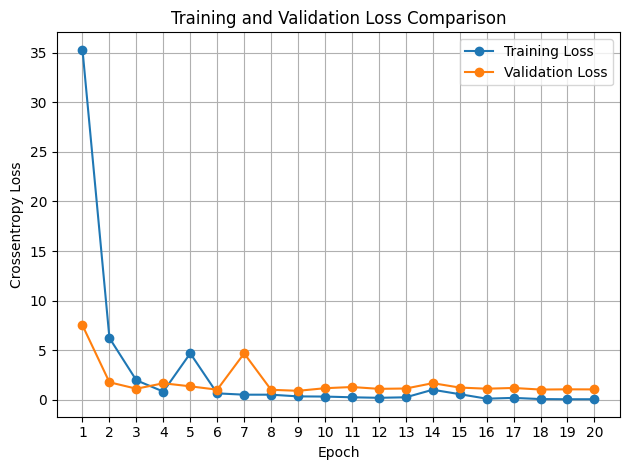

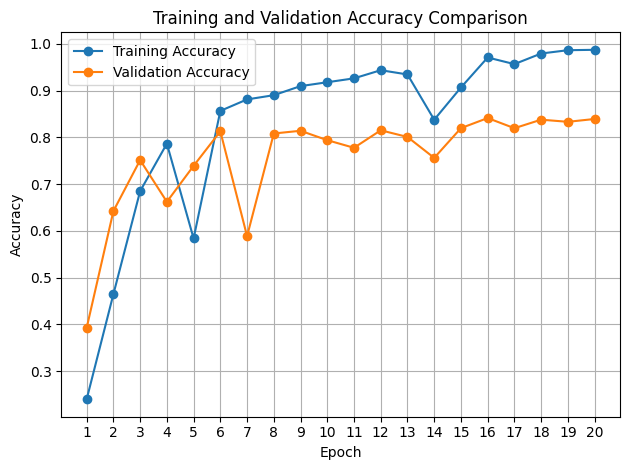

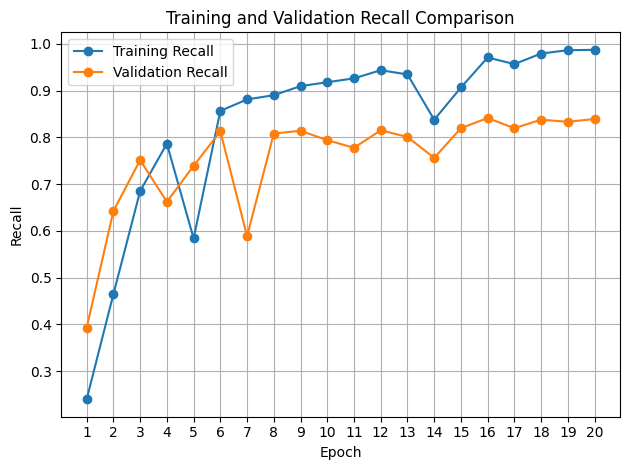

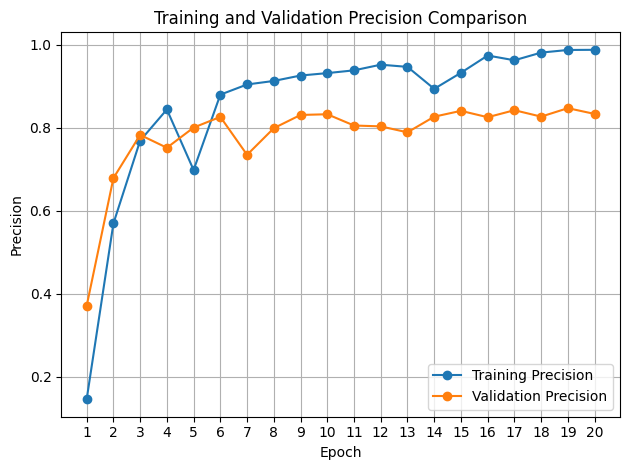

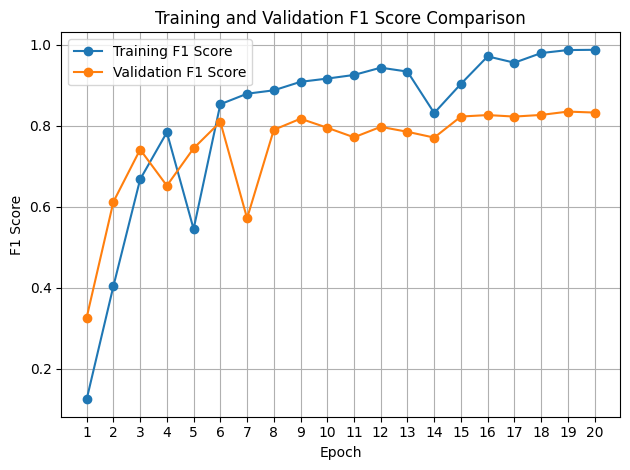

In [64]:
plot_losses(range(1, epochs+1), train_losses, val_losses)
plot_accuracy(range(1, epochs+1), train_accuracies, val_accuracies)
plot_recall(range(1, epochs+1), train_recalls, val_recalls)
plot_precision(range(1, epochs+1), train_precisions, val_precisions)
plot_f1_score(range(1, epochs+1), train_f1_scores, val_f1_scores)

# Evaluate on Test Data

In [66]:
test_accuracy, test_recall, test_precision, test_f1_score, test_loss = evaluate(model, test_dataloader, criterion)
print(
    "test accuracy {:8.3f} | test recall {:.3f} | "
    "test precision {:.3f} | test f1 score {:.3f}".format(
        test_accuracy, test_recall,
        test_precision, test_f1_score 
    )
)

test accuracy    0.810 | test recall 0.810 | test precision 0.808 | test f1 score 0.8041 score 0.8041 - loss 1.13141


In [72]:
def predict(text: str, vocab: Vocab, model: nn.Module, max_length: int) -> int:
    """
    Predicts the class label for a given text.

    Args:
        text (str): Input text to be classified.
        vocab (Vocab): Vocabulary object used to encode the text.
        model (nn.Module): Trained neural network model for prediction.
        max_length (int): Maximum length of the input text sequences.

    Returns:
        int: Predicted class label.
    """
    # Preprocess the input text:
    text = preprocess_text(text)
    
    # Encode the text using the vocabulary:
    encoded_text = vocab(tokenizer(text))
    
    # Pad the encoded text to the maximum length:
    encoded_text = pad_sequence(encoded_text, max_length)
    
    # Convert the encoded text to a tensor and add a batch dimension:
    encoded_text = torch.LongTensor(encoded_text).unsqueeze(0)
    
    # Predict the class label using the model:
    output = model(encoded_text).argmax(1)
    
    return output.item()


In [74]:
sample_test = X_test[6]
display(sample_test)
sample_label = y_test[6]
display(sample_label)

ix_to_label[predict(sample_test, vocab, model, max_length)]

'I paid a company named XXXX XXXX XXXX a total of {$14000.00} over several cards and transactions for a custom e-commerce website and coaching services. They made all kind of promises of income between $ XXXX- $ XXXX a year. It has been over a year and I find that I have not made a penny. Besides that the coaching did n\'t exist and the " custom \'\' site was nothing more than a substandard, rudimentary, cookie cutter that was never completed. They never finished the logo, never provided any marketing or the coding thumb drive as promised. They ripped me off and I am hoping that someone at my bank can help me get my money back. This company is still operating and I would like to dispute these charges. Services were not rendered and what I received was not what was described. I will be reporting them to the FTC as they are clearly violating the laws and need to be shut down. Please help me.'

'Theft/Dispute Reporting'

'Theft/Dispute Reporting'

There's an overfitting which we will tackle next. This is a milestone where we found that the problem is solveable